In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
import requests
from datetime import datetime
from tqdm import tqdm

In [35]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]


    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)

    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [36]:
df = get_energy_data()

  0%|          | 0/255 [00:00<?, ?it/s]/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_14421/1783941483.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 255/255 [00:25<00:00,  9.82it/s]


In [37]:
df.tail()

,Netzlast_Gesamt
date_time,
2023-11-12 03:00:00,38687.25
2023-11-12 04:00:00,39289.50
2023-11-12 05:00:00,39311.25
2023-11-12 06:00:00,39640.50
2023-11-12 07:00:00,10095.50


Rename column for convenience

In [38]:
df = df.rename(columns={"Netzlast_Gesamt": "gesamt"})

Rescale Netzlast so it fits requirements

In [39]:
df['gesamt'] = df['gesamt'] / 1000

Check dtypes and if columns contain and missing values

In [40]:
df.dtypes

gesamt    float64
dtype: object

In [41]:
df.isna().any()

gesamt    False
dtype: bool

Define weekday column

In [42]:
df["weekday"] = df.index.weekday #Monday=0, Sunday=6
#df["time"] = df.index.strftime("%H:%M")

In [43]:
# from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
# 
# en_df = get_energy_data()
# df = prepare_data(en_df)

Lead times are

In [44]:
horizons_def = [36, 40, 44, 60, 64, 68]#[24 + 12*i for i in range(5)]
horizons_def

[36, 40, 44, 60, 64, 68]

Adapt horzions so they actually fit

In [45]:
horizons = [h+1 for h in horizons_def]
horizons

[37, 41, 45, 61, 65, 69]

In [46]:
def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [47]:
LAST_IDX = -1
LAST_DATE = df.iloc[LAST_IDX].name

Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [48]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
horizon_date

[Timestamp('2023-11-12 04:00:00'),
 Timestamp('2023-11-12 08:00:00'),
 Timestamp('2023-11-12 12:00:00'),
 Timestamp('2023-11-13 04:00:00'),
 Timestamp('2023-11-13 08:00:00'),
 Timestamp('2023-11-13 12:00:00')]

quantile levels

In [49]:
tau = [.025, .25, .5, .75, .975]

In [50]:
#rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

In [51]:
last_t = 100
for i,d in enumerate(horizon_date):
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = df.iloc[:LAST_IDX]
    
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    pred_baseline[i,:] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)
    

In [52]:
pred_baseline

array([[32.75283125, 35.1108125 , 37.256     , 41.62225   , 47.16964375],
       [38.5722875 , 40.874875  , 43.161875  , 46.651375  , 52.71676875],
       [44.13631875, 47.194125  , 49.84125   , 54.2904375 , 61.492075  ],
       [35.41129375, 38.9119375 , 41.767125  , 45.7239375 , 52.79011875],
       [41.1121625 , 57.72125   , 61.131125  , 65.567     , 73.112275  ],
       [46.8640625 , 60.893375  , 64.1785    , 66.999875  , 74.7590625 ]])

Visually check if quantiles make sense

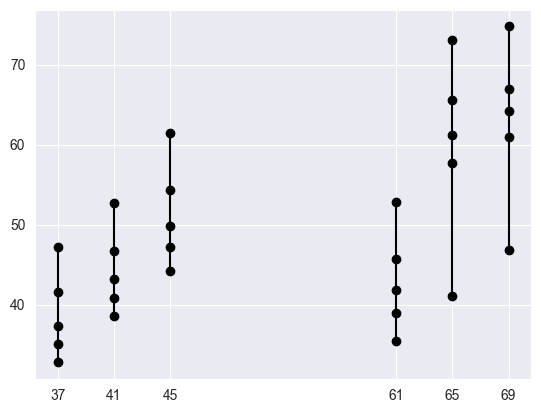

In [53]:
x = horizons
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [54]:
from datetime import datetime, date, timedelta
date_str = datetime.today().strftime('%Y%m%d')

In [55]:
date_str = date.today() #- timedelta(days=1)
date_str = date_str.strftime('%Y-%m-%d')
date_str

'2023-11-12'

In [56]:
df_sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-12,energy,36 hour,32.752831,35.110813,37.256000,41.622250,47.169644
1,2023-11-12,energy,40 hour,38.572288,40.874875,43.161875,46.651375,52.716769
2,2023-11-12,energy,44 hour,44.136319,47.194125,49.841250,54.290437,61.492075
3,2023-11-12,energy,60 hour,35.411294,38.911938,41.767125,45.723937,52.790119
4,2023-11-12,energy,64 hour,41.112163,57.721250,61.131125,65.567000,73.112275
5,2023-11-12,energy,68 hour,46.864063,60.893375,64.178500,66.999875,74.759062


In [57]:
#need to change this
PATH = "/save/to/path"


df_sub.to_csv(PATH+date_str+"_power_benchmark.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/save/to'